# Breast Cancer Detection

### 1.  Define the Config.

In [1]:
import os
INPUT_DATASET = "E:/CODE/datasets/breast_cancer_detection/original/"
BASE_PATH = "C:/Users/prasr/Desktop/tmp_dataset/idc"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
BATCH_SIZE = 32

### 2.  Import the required packages.

In [2]:
import logging
import numpy as np
from imutils import paths
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow.keras.utils as np_utils
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

K.set_image_data_format('channels_last')
logging.getLogger('tensorflow').disabled = True
tf.__version__

'2.3.1'

We are going to run on the GPU so this is to check if we are able to list and connect with the GPU.

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16535784175432360743,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17846528488670760984
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3129973145
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4538389907006246060
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16922319251131427739
 physical_device_desc: "device: XLA_GPU device"]

In [6]:
# Get config data
trainPaths=list(paths.list_images(TRAIN_PATH))
lenTrain=len(trainPaths)
lenVal=len(list(paths.list_images(VAL_PATH)))
lenTest=len(list(paths.list_images(TEST_PATH)))

### 3. View sample data.

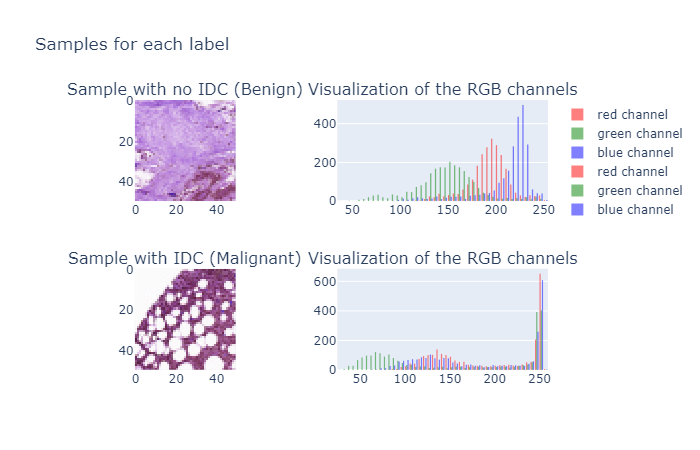

In [13]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cv2
img_1 = cv2.imread(trainPaths[0])
img_2 = cv2.imread(trainPaths[143150])
# fig = px.imshow(img)
# fig.show()
fig = make_subplots(rows = 2, cols= 2, subplot_titles=("Sample with no IDC (Benign)","Visualization of the RGB channels", "Sample with IDC (Malignant)","Visualization of the RGB channels"))
# We use go.Image because subplots require traces, whereas px functions return a figure
fig.add_trace(go.Image(z=img_1), 1, 1)
for channel, color in enumerate(['red', 'green', 'blue']):
    fig.add_trace(go.Histogram(x=img_1[..., channel].ravel(), opacity=0.5,
                               marker_color=color, name='%s channel' %color), 1, 2)
    
fig.add_trace(go.Image(z=img_2), 2, 1)
for channel, color in enumerate(['red', 'green', 'blue']):
    fig.add_trace(go.Histogram(x=img_2[..., channel].ravel(), opacity=0.5,
                               marker_color=color, name='%s channel' %color), 2, 2)


fig.update_layout(height=800.,title = 'Samples for each label')
# import plotly.io as pio
# pio.write_html(fig, file='figure.html', auto_open=True)
fig.show("png")


Get the labels and finidng the class wights as this is an imbalanced classification.

In [8]:
trainLabels=[int(trainpath.split(os.path.sep)[-2]) for trainpath in trainPaths]
trainLabels
trainLabels= np_utils.to_categorical(trainLabels)
classTotals=trainLabels.sum(axis=0)
classWeight=classTotals.max()/classTotals

In [9]:
classWeight = {0:classWeight[0],1:classWeight[1]}

In [10]:
classWeight

{0: 1.0, 1: 2.5260549}

View the class distribution in the traing set

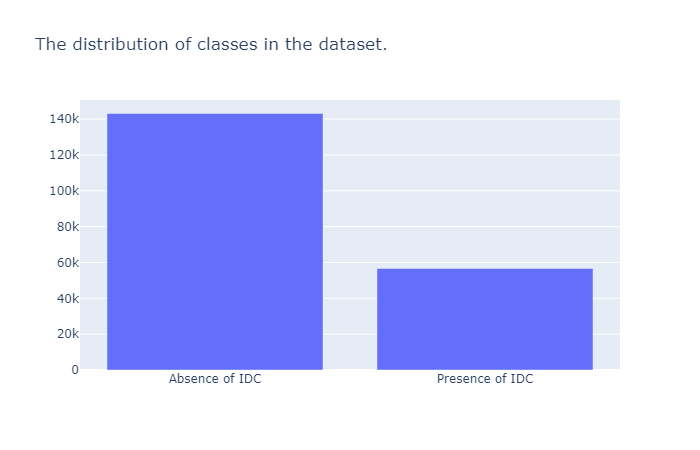

In [14]:
import plotly.io as pio
labels =[int(trainpath.split(os.path.sep)[-2]) for trainpath in trainPaths]
from collections import Counter
label_counts = Counter(labels)
fig = dict({
    "data": [{"type": "bar",
              "x": ['Absence of IDC','Presence of IDC'],
              "y": list(label_counts.values())
             }],
    "layout": {"title": {"text": "The distribution of classes in the dataset."}}
})
pio.show(fig,"png")

### 4.  Data Augumentation

In [11]:
train_data_aug = ImageDataGenerator(
                    rescale = 1/255.0,
                    rotation_range = 20,
                    zoom_range = 0.05,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.05,
                    vertical_flip=True,
                    horizontal_flip=True,
                    fill_mode="nearest")
val_data_aug = ImageDataGenerator(rescale=1.0/255.0)

In [12]:
train_generator = train_data_aug.flow_from_directory(
                    TRAIN_PATH,
                    class_mode="categorical",
                    target_size = (48,48),
                    color_mode = "rgb",
                    shuffle=True,
                    batch_size= BATCH_SIZE
                    )

Found 199818 images belonging to 2 classes.


In [13]:
val_generator = val_data_aug.flow_from_directory(
              VAL_PATH,
              class_mode="categorical",
              target_size=(48,48),
              color_mode="rgb",
              shuffle=False,
              batch_size=BATCH_SIZE)
test_generator = val_data_aug.flow_from_directory(
              TEST_PATH,
              class_mode="categorical",
              target_size=(48,48),
              color_mode="rgb",
              shuffle=False,
              batch_size=BATCH_SIZE)

Found 22201 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


### 5.  Build the Model components

#### a. The identiy Block

![identity block](identity_block.png "identity_block")

In [14]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F2, kernel_size = (f,f),strides = (1,1),padding = 'same',name = conv_name_base+'2b',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size = (1,1),strides = (1,1),padding = 'valid',name = conv_name_base+'2c',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)

    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

Testing the identity block

In [15]:
np.random.seed(1)
X = np.random.randn(3, 4, 4, 6)
# print('X:',X)
out = identity_block(X, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
print("out = ",out[0][1][1].numpy())

out =  [0.         0.         0.         0.         0.         0.25973427]


### b. Convoultional Block

![conv block](conv_block.png "convolutional block")

In [16]:

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X =  Conv2D(F2, (f,f), strides = (1,1),padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X =  BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X =  Activation('relu')(X)

    X = Conv2D(F3, (1,1),strides = (1,1),name = conv_name_base+'2c',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)

    X_shortcut =  Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base+'1')(X_shortcut)

    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

Testing the Convoultional blocks

In [17]:
X = np.random.randn(3,4,4,6)
out = convolutional_block(X,f = 2, filters= [2,4,6],stage=1,block='a')
print(out[0][1][1].numpy())

[0.         0.         0.         1.1208296  0.14083228 0.13244952]


### 6. Assembling the pieces to form ResNet-50

Detailed View of the layers that form the ResNet-50 architecture is as follows:
    ![detailed explained architecture](detailed_eplaination_resnet_1.jpg "detailed eplaination resnet")
The same architecture with respect to the blocks defined above:
    ![architecture with blocks](ResNet.png "ResNet with the defined blocks")

In [18]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)                                                                         
    X = identity_block(X,3,[128,128,512],stage = 3,block = 'b')
    X = identity_block(X,3,[128,128,512],stage = 3,block = 'c')
    X = identity_block(X,3,[128,128,512],stage = 3,block = 'd')

    # Stage 4 
    X = convolutional_block(X, f= 3,filters = [256,256,1024],stage = 4,block = 'a',s= 2)
    X = identity_block(X,3,[256,256,1024],stage = 4,block = 'b')
    X = identity_block(X,3,[256,256,1024],stage = 4,block = 'c')
    X = identity_block(X,3,[256,256,1024],stage = 4,block = 'd')
    X = identity_block(X,3,[256,256,1024],stage = 4,block = 'e')
    X = identity_block(X,3,[256,256,1024],stage = 4,block = 'f')

    # Stage 5 
    X = convolutional_block(X, f= 3,filters = [512,512,2048],stage = 5,block = 'a',s= 2)
    X = identity_block(X,3,[512,512,2048],stage = 5,block = 'b')
    X = identity_block(X,3,[512,512,2048],stage = 5,block = 'c')

    X = AveragePooling2D(pool_size = (2,2),name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

### 7.0 Initialize the model.

In [19]:
model = ResNet50(input_shape = (48, 48, 3), classes = 2)

### 8.0 complile the model.

In [20]:
model.compile(loss="binary_crossentropy",optimizer ='adam' ,metrics=["accuracy"])

In [21]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

### 9.0 Fit the model

In [22]:
with tf.device('/GPU:0'):
    trained_model=model.fit(
          train_generator,
          steps_per_epoch=lenTrain//BATCH_SIZE,
          validation_data=val_generator,
          validation_steps=lenVal//BATCH_SIZE,
          class_weight=classWeight,
          epochs=10, workers=16)

Epoch 1/10
6244/6244 [==============================] - 1069s 171ms/step - loss: 0.8333 - accuracy: 0.7856 - val_loss: 0.4311 - val_accuracy: 0.8257
Epoch 2/10
6244/6244 [==============================] - 946s 152ms/step - loss: 0.7645 - accuracy: 0.7731 - val_loss: 0.3833 - val_accuracy: 0.8357
Epoch 3/10
6244/6244 [==============================] - 953s 153ms/step - loss: 0.5751 - accuracy: 0.8222 - val_loss: 0.3556 - val_accuracy: 0.8515
Epoch 4/10
6244/6244 [==============================] - 952s 152ms/step - loss: 0.5275 - accuracy: 0.8388 - val_loss: 0.3531 - val_accuracy: 0.8415
Epoch 5/10
6244/6244 [==============================] - 972s 156ms/step - loss: 0.5019 - accuracy: 0.8471 - val_loss: 0.8173 - val_accuracy: 0.5859
Epoch 6/10
6244/6244 [==============================] - 929s 149ms/step - loss: 0.4933 - accuracy: 0.8501 - val_loss: 0.4076 - val_accuracy: 0.8279
Epoch 7/10
6244/6244 [==============================] - 933s 149ms/step - loss: 0.4899 - accuracy: 0.8531 - val

### 10. To Evaluvate the model

In [35]:
print("Now evaluating the model")
test_generator.reset()
pred_indices=model.predict_generator(test_generator,steps=(lenTest//BATCH_SIZE)+1)
pred_indices=np.argmax(pred_indices,axis=1)
print(classification_report(test_generator.classes, pred_indices, target_names=test_generator.class_indices.keys()))
cm=confusion_matrix(test_generator.classes,pred_indices)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(cm)
print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')
print(f'Sensitivity: {sensitivity}')


Now evaluating the model
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     39736
           1       0.82      0.62      0.71     15769

    accuracy                           0.85     55505
   macro avg       0.84      0.78      0.81     55505
weighted avg       0.85      0.85      0.85     55505

[[37598  2138]
 [ 5943  9826]]
Accuracy: 0.8544095126565174
Specificity: 0.6231213139704483
Sensitivity: 0.946194886249245


### 11. Visualize the confusion matrix.

In [50]:
def plot_confusion_matrix_1(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### a.  UnNormalized Confusion Matrix

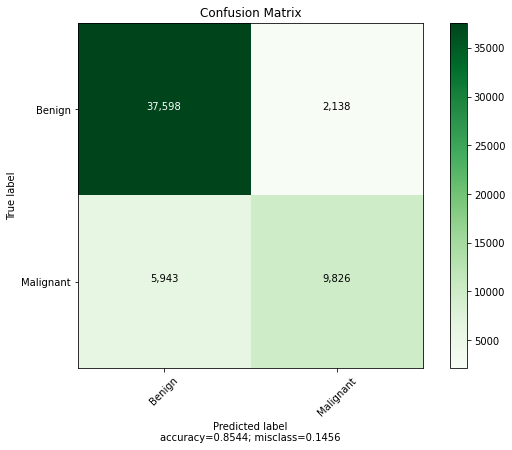

In [51]:
plot_confusion_matrix_1(cm, 
                  normalize    = False,
                  target_names = ['Benign','Malignant'],
                  title        = "Confusion Matrix")

#### b. Normalized Confusion Matrix

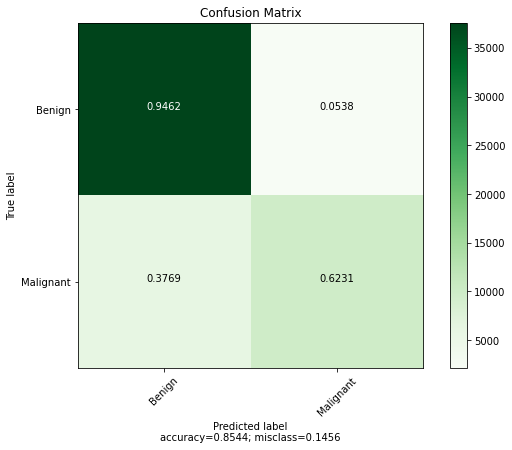

In [53]:
plot_confusion_matrix_1(cm, 
                  normalize    = True,
                  target_names = ['Benign','Malignant'],
                  title        = "Confusion Matrix")

We can see how its performance using ResNet-50 is not bad let's see how it performs on a shallower ResNet like ResNet-18 or 34.